In [ ]:
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from datetime import datetime
import networkx as nx
import nxviz as nv
import re
import os
from email.parser import Parser
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Counter
%matplotlib inline
import warnings
from wordcloud import WordCloud

warnings.filterwarnings("ignore")

### plain wordcloud visualization based on frequency

In [ ]:
file_dir = '/Users/itschris/Desktop/enron/enron_subset.csv'

with open(file_dir, "r") as f:
    data = f.read()

print(data)

In [ ]:
email = Parser().parsestr(data)

# get the body of the email
body = email.get_payload()

print(body)

In [9]:
# save the body to a file to desktop
with open('/Users/itschris/Desktop/body.txt', 'w') as f:
    f.write(body)

In [11]:
# separate the body into words (tokenize)
words = body.split()

# count the words
word_count = Counter(words)

# create a dataframe from the word count
word_count_df = pd.DataFrame(word_count.items(), columns=['word', 'count'])

# sort the dataframe by count
word_count_df = word_count_df.sort_values(by='count', ascending=False)

In [12]:
# top n words
top_words = word_count_df.head(60)

In [13]:
top_words = str(top_words)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = 'english', 
                min_font_size = 10).generate(top_words)

In [ ]:
# plot the WordCloud image                        
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### EDA analysis with ydata profiling

In [3]:
from ydata_profiling import ProfileReport

In [33]:
enron_df = pd.read_csv("/Users/itschris/Desktop/Pontus-X/repo/PETS-marketplace-adv/data/inputs/enron/enron_subset.csv")

# preprocessing 
def parse_email(content):
    email = Parser().parsestr(content)
    return email.get_payload()

enron_df['email_body'] = enron_df['message'].apply(parse_email)

In [34]:
email_body_df = enron_df.drop(columns=['message'])

email_body_df.head()

,file,email_body
0,allen-p/_sent_mail/1.,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,Let's shoot for Tuesday at 11:45.


In [ ]:
# NLP preprocessing 
import nltk

def nlp(content):
    content = content.strip()
    token = nltk.word_tokenize(content)
    stopwords = nltk.corpus.stopwords.words('english')
    filtered_token = [t for t in token if t not in string.punctuation and t.lower() not in stopwords]

    return ' '.join(filtered_token)

email_body_df['clean_email_body'] = email_body_df['email_body'].apply(nlp)
clean_email_body_df = email_body_df.drop(columns=['email_body'])
clean_email_body_df.head()

,file,clean_email_body
0,allen-p/_sent_mail/1.,forecast
1,allen-p/_sent_mail/10.,Traveling business meeting takes fun trip Espe...
2,allen-p/_sent_mail/100.,test successful way go
3,allen-p/_sent_mail/1000.,Randy send schedule salary level everyone sche...
4,allen-p/_sent_mail/1001.,Let 's shoot Tuesday 11:45


In [39]:
# create EDA report 

profile = ProfileReport(clean_email_body_df, title="Profiling Report", explorative = True , sensitive=False)  # , tsmode=True)

In [ ]:
profile

### Clustering

In [42]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer

def stemming(content):
    # tokenize 
    content = content.strip()
    content = re.sub(r'\W+', ' ', content)
    content = re.sub(r'\d+', '', content)

    token = nltk.word_tokenize(content)
    stopwords = nltk.corpus.stopwords.words('english')
    
    # stem the word
    stemmer = SnowballStemmer("english")
    
    stemmed_token = [stemmer.stem(t) for t in token if t not in string.punctuation and t.lower() not in stopwords]

    return ' '.join(stemmed_token)

In [44]:
clean_email_body_df['stemmed_email_body'] = clean_email_body_df['clean_email_body'].apply(stemming)
stem_email_body_df = clean_email_body_df.drop(columns=['clean_email_body'])
stem_email_body_df.head()

,file,stemmed_email_body
0,allen-p/_sent_mail/1.,forecast
1,allen-p/_sent_mail/10.,travel busi meet take fun trip especi prepar p...
2,allen-p/_sent_mail/100.,test success way go
3,allen-p/_sent_mail/1000.,randi send schedul salari level everyon schedu...
4,allen-p/_sent_mail/1001.,let shoot tuesday


In [45]:
# clustering 
from sklearn.feature_extraction.text import TfidfVectorizer

# Transform the cleaned text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(stem_email_body_df['stemmed_email_body'])

In [47]:
# k-means
from sklearn.cluster import KMeans

# Apply K-Means with a predetermined number of clusters
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)

# Get the cluster assignments
labels_kmeans = kmeans.labels_
stem_email_body_df['cluster_kmeans'] = labels_kmeans

In [48]:
# DBSCAN

from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
dbscan.fit(X_tfidf)

# Get the cluster assignments
labels_dbscan = dbscan.labels_
stem_email_body_df['cluster_dbscan'] = labels_dbscan

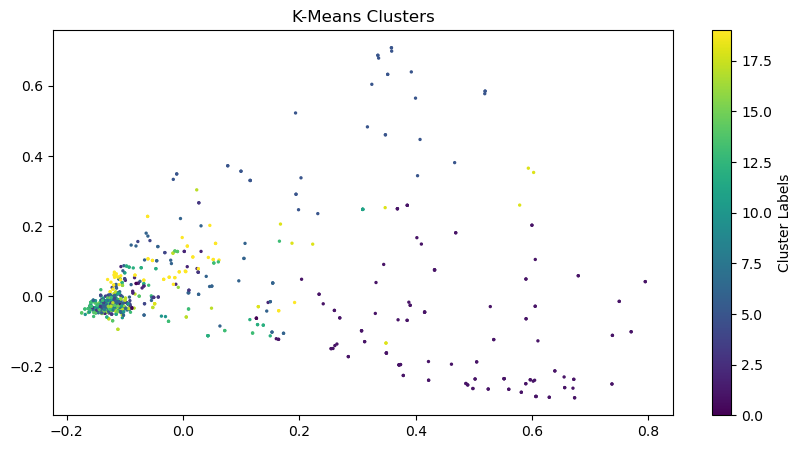

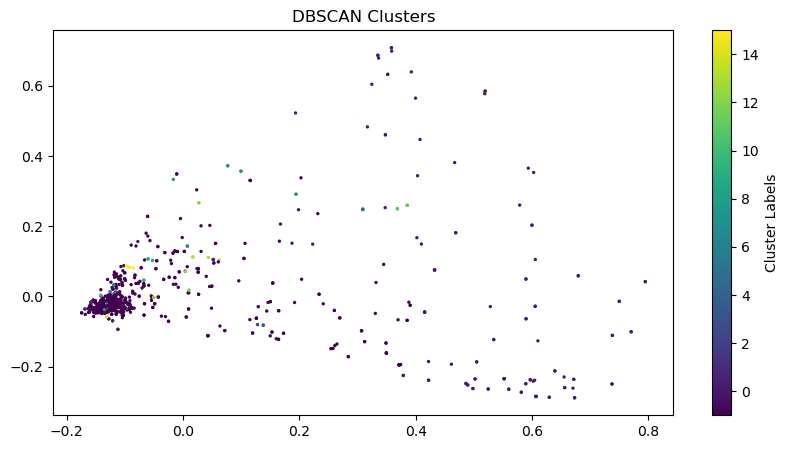

In [56]:
# visualization
from sklearn.decomposition import PCA

def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=2)
    # for i, name in enumerate(stem_email_body_df['file']):
    #     plt.text(X_pca[i, 0], X_pca[i, 1], name[-4:], fontsize=8, alpha=0.7)
    
    plt.colorbar(scatter, label="Cluster Labels")

    plt.title(title)
    plt.show()

# Reduce dimensions to 2 for visualization
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())

# Visualize clusters
plot_clusters(X_pca, labels_kmeans, 'K-Means Clusters')
plot_clusters(X_pca, labels_dbscan, 'DBSCAN Clusters')
